In [13]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
# import neptune.new as neptune
# from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits
from tqdm import tqdm
import random

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [5]:
image_list_g = sorted(os.listdir("/data/HSC/HSC_v6/step1/g_band"))
image_list_r = sorted(os.listdir("/data/HSC/HSC_v6/step1/r_band"))
image_list_i = sorted(os.listdir("/data/HSC/HSC_v6/step1/i_band"))
image_list_z = sorted(os.listdir("/data/HSC/HSC_v6/step1/z_band"))
image_list_y = sorted(os.listdir("/data/HSC/HSC_v6/step1/y_band"))

photozdata = pd.read_csv('/data/HSC/HSC_v6/HSC_v6.csv')
photozdata.describe()

b = np.argsort(photozdata['object_id'])
sorted_photozdata = photozdata.iloc[b][:]
photozdata = sorted_photozdata

hf = h5py.File('/data/HSC/HSC_v6/step3/64x64.hdf5', 'a')

KeyboardInterrupt: 

In [7]:
photozdata = pd.read_csv('/data/HSC/HSC_v6/HSC_v6.csv')

In [9]:
for (columnName, columnData) in photozdata.iteritems():
    print(columnName)

object_id
specz_redshift_err
specz_redshift
specz_mag_i
specz_name
specz_ra
specz_dec
specz_flag_homogeneous
ra
dec
coord
skymap_id
g_cmodel_mag
r_cmodel_mag
i_cmodel_mag
z_cmodel_mag
y_cmodel_mag
g_cmodel_magsigma
r_cmodel_magsigma
i_cmodel_magsigma
z_cmodel_magsigma
y_cmodel_magsigma


/tmp/ipykernel_3908204/3463937130.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():


  0%|          | 0/286401 [00:00<?, ?it/s]/tmp/ipykernel_3964677/478952715.py:51: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (columnName, columnData) in photozdata.iteritems():
  0%|          | 0/286401 [00:00<?, ?it/s]


ValueError: Unable to create dataset (name already exists)

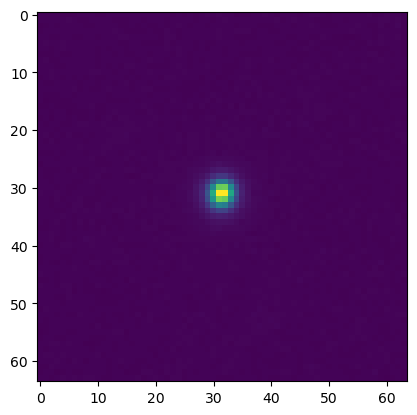

In [5]:
count = 0
size = len(image_list_g)
for i in tqdm(range(size)):

    object_id = image_list_g[i][0:17]

    five_band_image = []

    image_g = fits.open("/data/HSC/HSC_v6/step1/g_band/" + image_list_g[i])
    image_r = fits.open("/data/HSC/HSC_v6/step1/r_band/" + image_list_r[i])
    image_i = fits.open("/data/HSC/HSC_v6/step1/i_band/" + image_list_i[i])
    image_z = fits.open("/data/HSC/HSC_v6/step1/z_band/" + image_list_z[i])
    image_y = fits.open("/data/HSC/HSC_v6/step1/y_band/" + image_list_y[i])

    image_g_data = image_g[1].data
    image_r_data = image_r[1].data
    image_i_data = image_i[1].data
    image_z_data = image_z[1].data
    image_y_data = image_y[1].data
    
    # Update the pad values to extract the central 64x64 section
    pad1 = int((120 - 64) / 2)
    pad2 = 120 - 64 - pad1
    pad3 = int((120 - 64) / 2)
    pad4 = 120 - 64 - pad3

    im_g = image_g_data[pad1:pad1 + 64, pad3:pad3 + 64]
    im_r = image_r_data[pad1:pad1 + 64, pad3:pad3 + 64]
    im_i = image_i_data[pad1:pad1 + 64, pad3:pad3 + 64]
    im_z = image_z_data[pad1:pad1 + 64, pad3:pad3 + 64]
    im_y = image_y_data[pad1:pad1 + 64, pad3:pad3 + 64]
    
    five_band_image.append(im_g)
    five_band_image.append(im_r)
    five_band_image.append(im_i)
    five_band_image.append(im_z)
    five_band_image.append(im_y)

    # Update five_band_image_reshape to store central 64x64 sections
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    
    # plt.imshow(five_band_image_reshape[0][0])

    photozdata_subset = photozdata.iloc[i]

    specz = photozdata_subset['specz_redshift']
    specz_reshape = np.reshape(specz, [1, 1])

    if count == 0:

        for (columnName, columnData) in photozdata.iteritems():

            if columnName == 'specz_name' or columnName == 'coord':

                hf.create_dataset(columnName, data=np.reshape(np.array(photozdata[columnName]).astype(str), [286401, 1]).astype('S')[i], maxshape=(None,))

            else:

                hf.create_dataset(columnName, data=photozdata[columnName][i: i + 1], maxshape=(None,))

        hf.create_dataset('image', data=five_band_image_reshape, chunks=True, maxshape=(None, 5, 64, 64))

    else:

        for (columnName, columnData) in photozdata.iteritems():

            hf[columnName].resize((hf[columnName].shape[0] + 1), axis=0)

            if columnName == 'specz_name' or columnName == 'coord':

                hf[columnName][hf[columnName].shape[0] - 1] = np.reshape(np.array(photozdata[columnName]).astype(str), [286401, 1]).astype('S')[i]

            else:

                hf[columnName][hf[columnName].shape[0] - 1] = photozdata[columnName][i: i + 1]

        hf['image'].resize((hf['image'].shape[0] + 1), axis=0)
        hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image_reshape

    count = count + 1

    image_g.close()
    image_r.close()
    image_i.close()
    image_z.close()
    image_y.close()

hf.close()

In [11]:
def make_hsc_v6_large_double(ntrain=204573,ntest=40914,nvalidation=40914):
    inputfile_1 = '5x64x64.hdf5'
    inputfile_2 = '5x127x127.hdf5'
    directory_1 = '/data/HSC/HSC_v6/temp/'
    directory_2 = '/data/HSC/HSC_v6/temp/'
    current_file_1 = os.path.join(directory_1, inputfile_1)
    current_file_2 = os.path.join(directory_2, inputfile_2)
    hf_1 = h5py.File(current_file_1,'r')
    hf_2 = h5py.File(current_file_2,'r')
    
    length_1 = len(hf_1['image'])
    length_2 = len(hf_2['image'])
    print(length_1)
    print(length_2)
    if length_1 != length_2:
        stop
    inds = random.sample(list(np.arange(length_1)),ntrain+ntest+nvalidation)
    inds_train = np.sort(inds[:ntrain])
    inds_test = np.sort(inds[ntrain:ntrain+ntest])
    inds_validation = np.sort(inds[ntrain+ntest:])

    part_1 = os.path.splitext(current_file_1)
    part_2 = os.path.splitext(current_file_2)
    subsizes = [ntrain, ntest, nvalidation]
    file_ends = ['_training', '_testing', '_validation']
    ind_list = [inds_train, inds_test, inds_validation]
    
    for subsize, file_end, ind in zip(subsizes, file_ends, ind_list):
        f_1 = h5py.File(part_1[0] + file_end + part_1[1], 'w')
        f_2 = h5py.File(part_2[0] + file_end + part_2[1], 'w')
        for k in hf_1.keys():
            tmp = hf_1[k]
            subshape = list(np.shape(tmp))
            subshape[0] = subsize
            dataset = f_1.create_dataset(k,shape=subshape,dtype=tmp.dtype)
            for i, index in enumerate(ind):
                dataset[i] = tmp[index]
            tmp = None
        for k in hf_2.keys():
            tmp = hf_2[k]
            subshape = list(np.shape(tmp))
            subshape[0] = subsize
            dataset = f_2.create_dataset(k,shape=subshape,dtype=tmp.dtype)
            for i, index in enumerate(ind):
                dataset[i] = tmp[index]
            tmp = None
        f_1.close()
        f_2.close()
    hf_1.close()
    hf_2.close()

In [8]:
import sys,os
import numpy as np
import pandas as pd
import random
import h5py

In [14]:
make_hsc_v6_large_double()

286401
286401


In [ ]:
DONE